# Training/Comparing Model Performance

This section is going to cover training models and comparing their performance using only the training set. This is because while getting metrics on the testing set is possible by uploading the model predictions to Kaggle, it would be better (in my opinion) just to show how the models perform on the training data.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys, os


sys.path.append(os.path.abspath(os.path.join("..")))

pd.set_option("mode.copy_on_write", True)

In [2]:
train = pd.read_csv("../data/raw/train.csv", index_col="Id")
test = pd.read_csv("../data/raw/test.csv", index_col="Id")

In [3]:
y = train["SalePrice"].to_numpy()
train.drop(columns=["SalePrice"], inplace=True)

In [4]:
from src.data_pipelines import preprocessing, feature_eng, standard_scaling, minmax_scaler
from sklearn.pipeline import make_pipeline

feat_eng_pipeline = make_pipeline(
    preprocessing.set_output(transform="pandas"),
    feature_eng
)

standard_pipeline = make_pipeline(
    preprocessing.set_output(transform="pandas"),# Since feature_eng relies on column names
    feature_eng,
    standard_scaling
)

minmax_pipeline = make_pipeline(
    preprocessing.set_output(transform="pandas"),# Since feautre_eng relies on column names
    feature_eng,
    minmax_scaler
)

In [5]:
training_pp = preprocessing.fit_transform(train)

In [6]:
training_fe = feat_eng_pipeline.fit_transform(train)

In [7]:
training_ss = standard_pipeline.fit_transform(train)

In [8]:
training_mm = standard_pipeline.fit_transform(train)

In [9]:
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

### Linear Regression

In [10]:
k_folds = 10

mae_pp = -cross_val_score(LinearRegression(), training_pp, y, scoring="neg_mean_absolute_error", cv=k_folds)
mae_fe = -cross_val_score(LinearRegression(), training_fe, y, scoring="neg_mean_absolute_error", cv=k_folds)
mae_ss = -cross_val_score(LinearRegression(), training_ss, y, scoring="neg_mean_absolute_error", cv=k_folds)
mae_mm = -cross_val_score(LinearRegression(), training_mm, y, scoring="neg_mean_absolute_error", cv=k_folds)

rmse_pp = -cross_val_score(LinearRegression(), training_pp, y, scoring="neg_root_mean_squared_error", cv=k_folds)
rmse_fe = -cross_val_score(LinearRegression(), training_fe, y, scoring="neg_root_mean_squared_error", cv=k_folds)
rmse_ss = -cross_val_score(LinearRegression(), training_ss, y, scoring="neg_root_mean_squared_error", cv=k_folds)
rmse_mm = -cross_val_score(LinearRegression(), training_mm, y, scoring="neg_root_mean_squared_error", cv=k_folds)

r2_pp = cross_val_score(LinearRegression(), training_pp, y, scoring="r2", cv=k_folds)
r2_fe = cross_val_score(LinearRegression(), training_fe, y, scoring="r2", cv=k_folds)
r2_ss = cross_val_score(LinearRegression(), training_ss, y, scoring="r2", cv=k_folds)
r2_mm = cross_val_score(LinearRegression(), training_mm, y, scoring="r2", cv=k_folds)

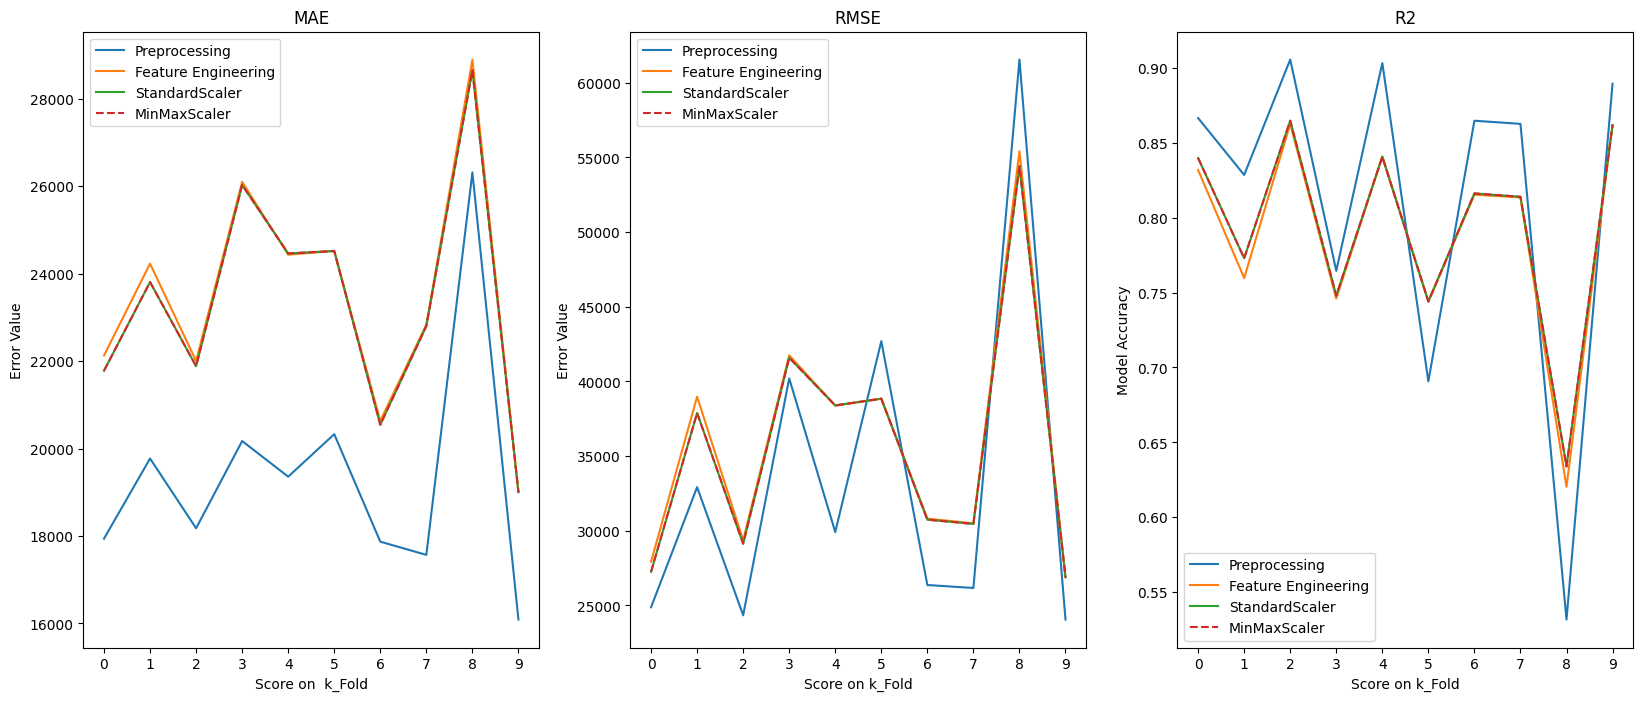

In [11]:
plt.subplots(figsize=(20,8), nrows=1, ncols=3)

plt.subplot(131)
plt.title("MAE")
plt.ylabel("Error Value")
plt.xlabel("Score on  k_Fold")
plt.plot(mae_pp)
plt.plot(mae_fe)
plt.plot(mae_ss)
plt.plot(mae_mm, "--")
plt.xticks([i for i in range(10)])
plt.legend(["Preprocessing", "Feature Engineering", "StandardScaler", "MinMaxScaler"])

plt.subplot(132)
plt.title("RMSE")
plt.ylabel("Error Value")
plt.xlabel("Score on k_Fold")
plt.plot(rmse_pp)
plt.plot(rmse_fe)
plt.plot(rmse_ss)
plt.plot(rmse_mm, "--")
plt.xticks([i for i in range(10)])
plt.legend(["Preprocessing", "Feature Engineering", "StandardScaler", "MinMaxScaler"])

plt.subplot(133)
plt.title("R2")
plt.ylabel("Model Accuracy")
plt.xlabel("Score on k_Fold")
plt.plot(r2_pp)
plt.plot(r2_fe)
plt.plot(r2_ss)
plt.plot(r2_mm, "--")
plt.xticks([i for i in range(10)])
plt.legend(["Preprocessing", "Feature Engineering", "StandardScaler", "MinMaxScaler"])
plt.show()

In all three plots, notice how both StandardScaler and MinMaxScaler track eachother perfectly. Not that this will be the case for the other models, but since StandardScaler is the preferred scaling method let's just stick to using that. Also what is quite odd is that the performance of the models tends to be worse when using data that has been engineered and scaled. On all of these metrics, it's evident that using just preprocessed data provides smaller error values and a higher level of accuracy on average. Knowing this, let's observe how well Linear Regression can predict values from the training set after its been trained and plot those values.

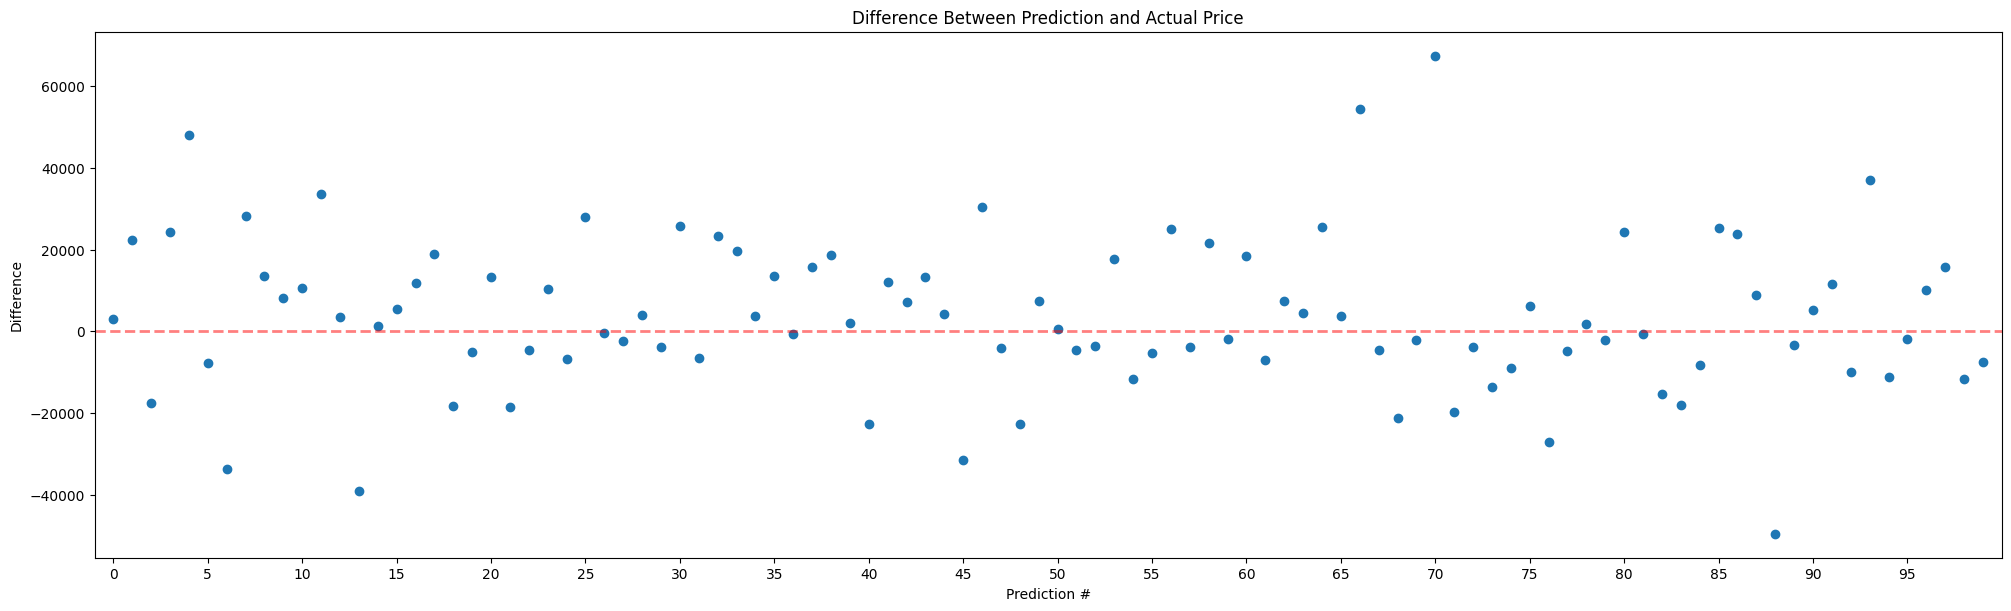

In [12]:
lin_reg = LinearRegression()
lin_reg.fit(training_pp, y)

pred = lin_reg.predict(training_pp)
diff = pred - y

plt.subplots(figsize=(20,6), layout="constrained")
plt.margins(x=.01)
plt.title("Difference Between Prediction and Actual Price")
plt.ylabel("Difference")
plt.xlabel("Prediction #")
plt.xticks([i*5 for i in range(100)])
plt.scatter(x=[i for i in range(100)], y=diff[:100])
plt.axhline(y=0, color="r", linestyle="--", alpha=.5, linewidth=2)
plt.show()

Using the first 100 values from the output, we can visualize the difference between prediction and actual value. Positive numbers represent the prediction was above the target, while negative is below. Expanding this plot can show some greater detail into what the predictions look like as a whole.

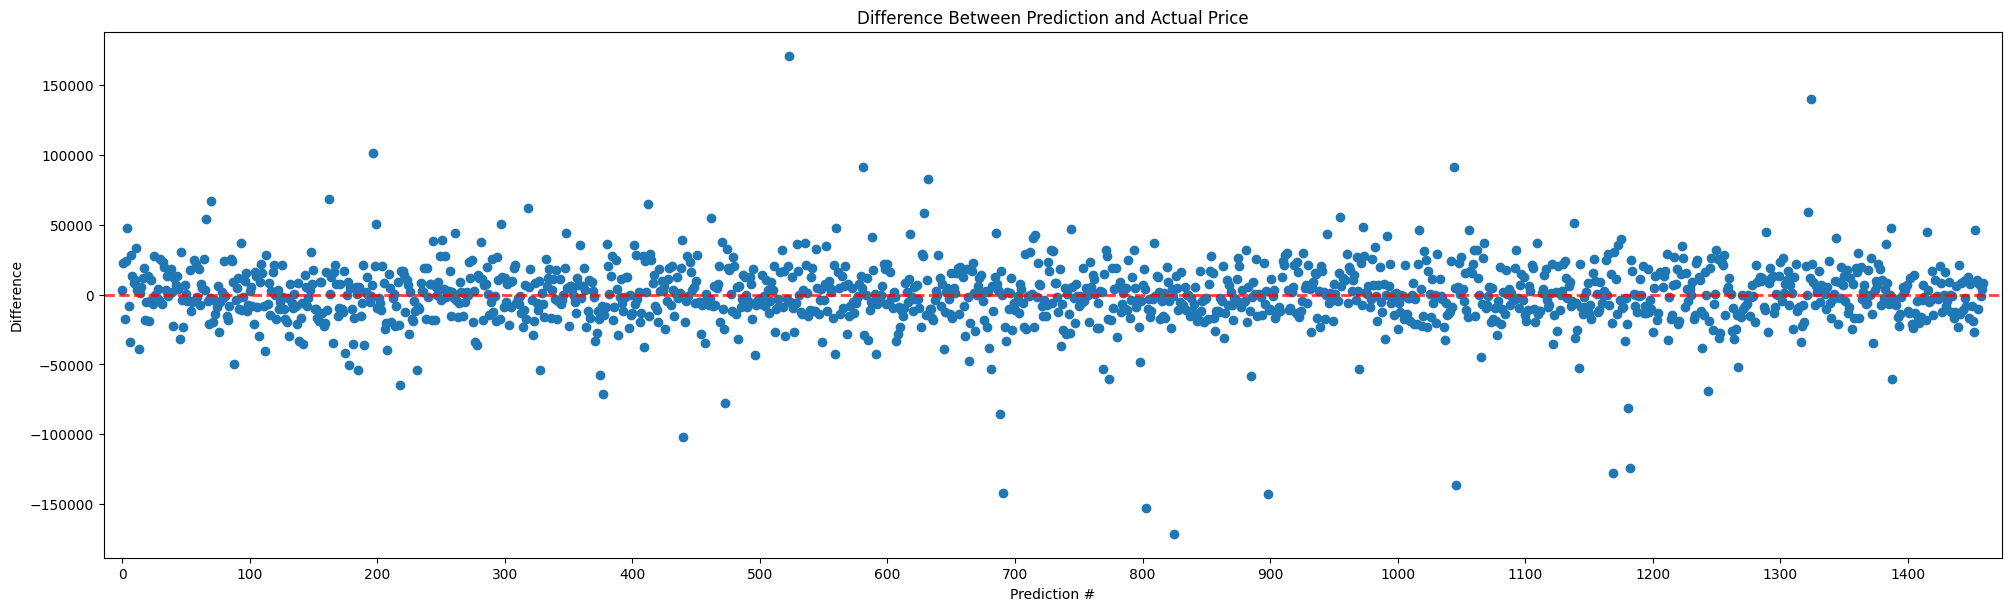

In [13]:
plt.subplots(figsize=(20,6), layout="constrained")
plt.margins(x=.01)
plt.title("Difference Between Prediction and Actual Price")
plt.ylabel("Difference")
plt.xlabel("Prediction #")
plt.xticks([i*100 for i in range(len(diff))])
plt.scatter(x=[i for i in range(len(diff))], y=diff)
plt.axhline(y=0, color="r", linestyle="--", alpha=.75, linewidth=2)
plt.show()

From a quick visual, most of the predictions fall between +50K/-25K. While this isn't very accurate, Linear Regression is a very simple model. Let's move on to compare performance of another model.

### DecisionTree Regressor

In [18]:
k_folds=10
mae_pp = -cross_val_score(DecisionTreeRegressor(), training_pp, y, scoring="neg_mean_absolute_error", cv=k_folds)
mae_fe = -cross_val_score(DecisionTreeRegressor(), training_fe, y, scoring="neg_mean_absolute_error", cv=k_folds)
mae_ss = -cross_val_score(DecisionTreeRegressor(), training_ss, y, scoring="neg_mean_absolute_error", cv=k_folds)
mae_mm = -cross_val_score(DecisionTreeRegressor(), training_mm, y, scoring="neg_mean_absolute_error", cv=k_folds)

rmse_pp = -cross_val_score(DecisionTreeRegressor(), training_pp, y, scoring="neg_root_mean_squared_error", cv=k_folds)
rmse_fe = -cross_val_score(DecisionTreeRegressor(), training_fe, y, scoring="neg_root_mean_squared_error", cv=k_folds)
rmse_ss = -cross_val_score(DecisionTreeRegressor(), training_ss, y, scoring="neg_root_mean_squared_error", cv=k_folds)
rmse_mm = -cross_val_score(DecisionTreeRegressor(), training_mm, y, scoring="neg_root_mean_squared_error", cv=k_folds)

r2_pp = cross_val_score(DecisionTreeRegressor(), training_pp, y, scoring="r2", cv=k_folds)
r2_fe = cross_val_score(DecisionTreeRegressor(), training_fe, y, scoring="r2", cv=k_folds)
r2_ss = cross_val_score(DecisionTreeRegressor(), training_ss, y, scoring="r2", cv=k_folds)
r2_mm = cross_val_score(DecisionTreeRegressor(), training_mm, y, scoring="r2", cv=k_folds)

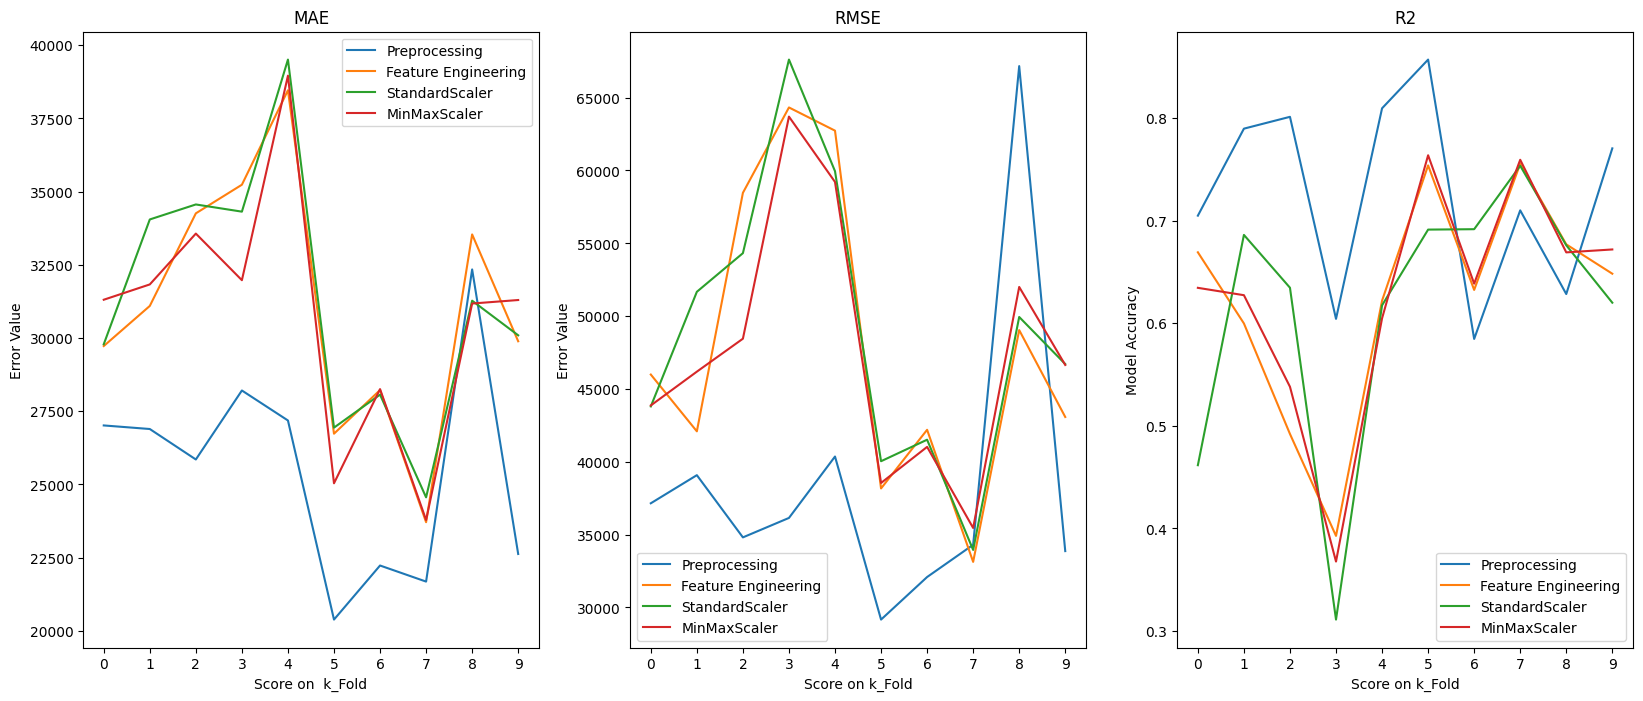

In [19]:
plt.subplots(figsize=(20,8), nrows=1, ncols=3)

plt.subplot(131)
plt.title("MAE")
plt.ylabel("Error Value")
plt.xlabel("Score on  k_Fold")
plt.plot(mae_pp)
plt.plot(mae_fe)
plt.plot(mae_ss)
plt.plot(mae_mm)
plt.xticks([i for i in range(10)])
plt.legend(["Preprocessing", "Feature Engineering", "StandardScaler", "MinMaxScaler"])

plt.subplot(132)
plt.title("RMSE")
plt.ylabel("Error Value")
plt.xlabel("Score on k_Fold")
plt.plot(rmse_pp)
plt.plot(rmse_fe)
plt.plot(rmse_ss)
plt.plot(rmse_mm)
plt.xticks([i for i in range(10)])
plt.legend(["Preprocessing", "Feature Engineering", "StandardScaler", "MinMaxScaler"])

plt.subplot(133)
plt.title("R2")
plt.ylabel("Model Accuracy")
plt.xlabel("Score on k_Fold")
plt.plot(r2_pp)
plt.plot(r2_fe)
plt.plot(r2_ss)
plt.plot(r2_mm)
plt.xticks([i for i in range(10)])
plt.legend(["Preprocessing", "Feature Engineering", "StandardScaler", "MinMaxScaler"])
plt.show()

Similarly to LinearRegression, preprocessing seems to perform better than the others. Although this is the case, according to these metrics, DecicionTreeRegressor performs worse than LinearRegression. Using the training data, let's verify these findings.

In [21]:
dtr = DecisionTreeRegressor()
dtr.fit(training_pp, y)

pred = dtr.predict(training_pp)
diff = pred - y

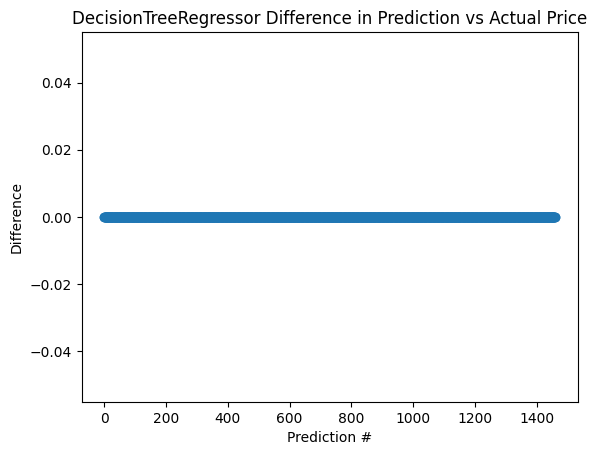

In [25]:
plt.scatter(x=[i for i in range(len(diff))], y=diff)
plt.title("DecisionTreeRegressor Difference in Prediction vs Actual Price")
plt.ylabel("Difference")
plt.xlabel("Prediction #")
plt.show()

In [27]:
dtr.score(training_pp, y)# Represents the r2 score on the model

1.0

Obviously this isn't right, unless the model has severly overfit the data that it's been provided. Using RandomizedSearchCV, let's attempt to prevent as much of this overfitting as possible to get a better idea of how the model might perform.

In [70]:
from scipy.stats import randint

dtr_params ={
    'splitter': ["best", "random"],
    'max_depth': [None,1,2,3,4,5,10,20],
    'min_samples_leaf': randint(low=1, high=20),
}

dtr_rnd_search = RandomizedSearchCV(DecisionTreeRegressor(random_state=12), param_distributions=dtr_params, n_iter=10, cv=3, scoring="neg_root_mean_squared_error", random_state=12)

In [72]:
dtr_rnd_search.fit(training_pp, y)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeR...ndom_state=12)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [None, 1, ...], 'min_samples_leaf': <scipy.stats....t 0x11c0432a0>, 'splitter': ['best', 'random']}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used h

In [74]:
pred = dtr_rnd_search.predict(training_pp)
diff = pred - y

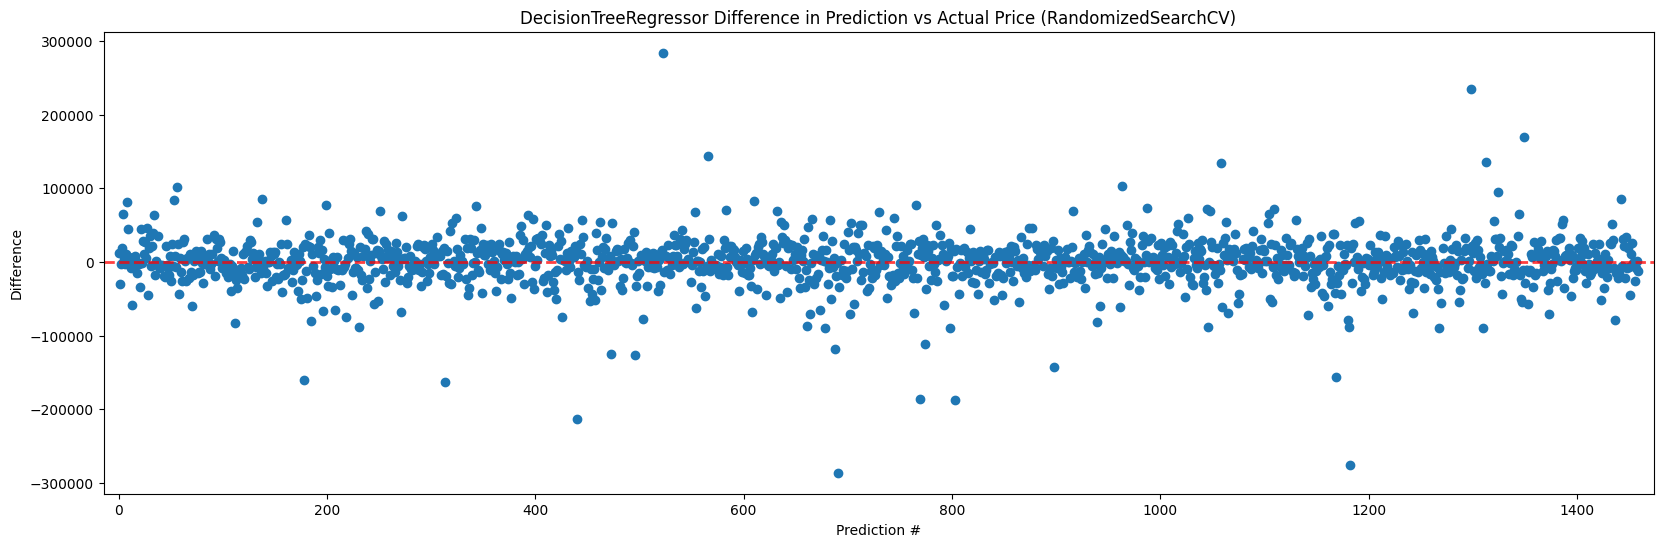

In [106]:
plt.subplots(figsize=(20,6))
plt.title("DecisionTreeRegressor Difference in Prediction vs Actual Price (RandomizedSearchCV)")
plt.ylabel("Difference")
plt.xlabel("Prediction #")
plt.margins(x=0.01)
plt.scatter(x=[i for i in range(len(diff))], y=diff)
plt.axhline(y=0, color="r", linestyle="--", alpha=.75, linewidth=2)
plt.show()

This new model looks a lot better than before. That is, not overfitted on the data as it previously was. Something that might standout compared to LinearRegression is that there are larger differences in the outliers. It does appear from a quick visual glance that this model is a bit more accurate. Let's verify this by checking the r2 score.

In [115]:
dtr_r2 = cross_val_score(dtr_rnd_search, training_pp, y, scoring="r2", cv=10)

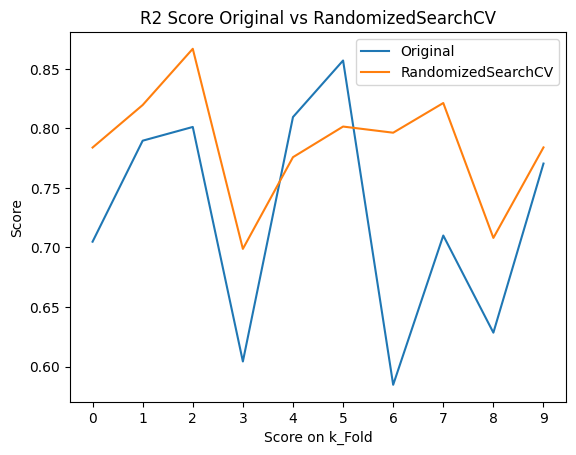

In [117]:
plt.plot(r2_pp)
plt.plot(dtr_r2)
plt.legend(["Original", "RandomizedSearchCV"])
plt.title("R2 Score Original vs RandomizedSearchCV")
plt.xlabel("Score on k_Fold")
plt.ylabel("Score")
plt.xticks([i for i in range(len(dtr_r2))])
plt.show()

It's clear that there is a noticeable difference in the r2 scores. On average the DecisionTreeRegressor performed better using the RandomizedSearchCV compared to the standalone version. Let's now try another model to see how the three compare to each other.